# Entrega 1, Grupo 02 - Arboles de decisión

- Santiago Alaniz, 5082647-6, santiago.alaniz@fing.edu.uy
- Bruno De Simone, 4914555-0, bruno.de.simone@fing.edu.uy
- María Usuca, 4891124-3, maria.usuca@fing.edu.uy



## Objetivo

Implementar un modelo que explique la deserción de estudiantes en la universidad.
 
Se pide:

- **(a)** Implementar una variante del algoritmo `ID3` agregandole los siguientes *hiperparametros*:
    - **i)** `min_samples_split`: cantidad mínima de ejemplos para generar un nuevo nodo; en caso de que no se llegue a la cantidad requerida, se debe formar una hoja.
    - **ii)** `min_split_gain`: ganancia mínima requerida para partir por un atributo; si ningún atributo llega a ese valor, se debe formar una hoja.
- **(b)** Utilizar el algoritmo implementado en **(a)** para construir un arbol de decision, evaluar resultados utilizando el dataset provisto.
- **(c)** Discuta como afecta la variacion de los hiperparametros con los modelos obtenidos.
- **(d)** Corra los algoritmos de `scikit-learn DecisionTreeClassifier, RandomForestClassifer` y compare los resultados.

El dataset que vamos a considerar (con su debido preprocesamiento) es *Predict students dropout and accademic success* con **36 atributos y mas de 4000 instancias.**

## Diseño

El apartado de diseño engloba todas las decisiones que tomamos a la hora de cumplir con las subtareas planteadas en la seccion anterior. 

Podemos identificar las siguientes etapas:

- **Carga de datos y Particionamiento**: Inicialización de los datos de los archivos CSV en un DataFrame de Pandas.
- **Pre-procesamiento de datos**: Transformaciones necesarias para que los datos puedan ser utilizados por el modelo.
- **Algoritmo**: Comentarios sobre la implementacion del algoritmo asi como las decisiones tomadas para su implementacion.
- **Evaluacion**: Prueba del modelo con diferentes hiperparametros.

### Carga de datos y particionamiento

En este apartado vamos a inicializar los datos siguiendo un esquema clásico de aprendizaje automático:

- **Carga de datos**: Cargamos los datos desde el fichero `csv` y los almacenamos en un `DataFrame` de `pandas`.
- **Particionamiento**: Particionamos los datos en dos conjuntos con `train_test_split` de `sklearn`.
    - `train` para entrenar el modelo.
    - `test` para evaluar el modelo.
    - `test` para evaluar el modelo final.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

CSV_PATH = './assets/data.csv'
SEED_NUMBER = 342
TEST_SIZE   = 0.4
DEVEL_SIZE  = 0.5

data = pd.read_csv(CSV_PATH, sep=';')

train, test = train_test_split(data, test_size= TEST_SIZE, random_state= SEED_NUMBER)
test, devel = train_test_split(test, test_size= DEVEL_SIZE, random_state= SEED_NUMBER)

train_indices   = set(train.index)
devel_indices   = set(devel.index)
test_indices    = set(test.index)

assert len(train_indices.intersection(devel_indices)) == 0
assert len(train_indices.intersection(test_indices)) == 0
assert len(devel_indices.intersection(test_indices)) == 0

print(f'<train: {train.shape[0]}, devel: {devel.shape[0]}, test: {test.shape[0]} >')

<train: 2654, devel: 885, test: 885 >


#### Redefinición de los valores del atributo objetivo `Target`.

El atributo objetivo `Target` es un atributo categórico que indica el desenlace del estudiante en su vida académica. Este atributo tiene 3 posibles valores: 

- `Enrolled` (inscripto)
- `Dropout` (abandono)
- `Graduate` (graduado).

La idea es construir un modelo sobre la diserción de los estudiantes, por lo que se decide agrupar los valores `Enrolled` y `Graduate` en un solo valor. 

-  0 &rarr; `Dropout`
-  1 &rarr; `Enrolled` o `Graduate`

**Nota**: 
La siguiente redefinición de atributos genera un desbalance en el atributo `Target`. De todas formas, continuaremos con el análisis.

In [2]:
for df in [train, devel, test]:
    df['Target'] = df['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)

train['Target'].value_counts()

Target
1    1806
0     848
Name: count, dtype: int64

#### Preprocesamiento de atributos continuos.

La [discretización](https://en.wikipedia.org/wiki/Data_binning) provee un mecanismo para particionar valores continuos en un número finito de valores discretos.

De los [36 atributos presentes](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) en el dataset, estos son listados como continuos:

- `Previous qualification (grade)`
- `Admission grade`
- `Unemployment rate`
- `Inflation rate`
- `GDP`

Para discretizar estos atributos, utlizaremos el modulo `scikit-learn.preprocessing`. 

En particular, la clase [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) con los siguientes parámetros:

- `encode= 'ordinal'` (codificación de los bins) devuelve un array de enteros indicando a que bin pertenece cada valor.
- `strategy='kmeans'` (estrategia de discretizacion) utiliza el algoritmo de [k-means](https://en.wikipedia.org/wiki/K-means_clustering) para determinar los bins. 

Finalmente, identificar estos atributos en el dataset es una tarea sencilla, ya que son los únicos del tipo `float64`.

***Nota***: 

Hay un error en la [documentación de los datos](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success), figuran como discretos dos campos representados con `float64`:

- `Curricular units 1st sem (grade)`
- `Curricular units 2nd sem (grade)` 

Decidimos discretizarlos de todas formas, ya que algunas de las entradas tienen valores no enteros.

In [3]:
from sklearn.preprocessing import KBinsDiscretizer

float64_cols = data.select_dtypes(include=['float64']).columns

for float64_col in float64_cols:
    float64_discretizer = KBinsDiscretizer(subsample=None, encode='ordinal', strategy='kmeans')
    train[[float64_col]]    = float64_discretizer.fit_transform(train[[float64_col]]).astype(int)
    devel[[float64_col]]    = float64_discretizer.transform(devel[[float64_col]]).astype(int)
    test[[float64_col]]     = float64_discretizer.transform(test[[float64_col]]).astype(int)

train[float64_cols].head()

,Previous qualification (grade),Admission grade,Curricular units 1st sem (grade),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP
1864,2,2,0,0,0,3,2
4367,1,1,4,2,4,1,2
4050,4,4,0,0,0,3,2
3765,2,2,3,2,2,1,3
3424,1,2,0,0,1,0,0


#### Comentario sobre el resto de los valores (discretos)

Los valores discretos son ideales para `ID3` porque el algoritmo puede manejarlos directamente sin necesidad de transformaciones adicionales. Sin embargo, es crucial tener en cuenta el número de valores únicos que un atributo discreto puede tener.

Somos conscientes que no existe un "buen número" de valores discretos distintos para un atributo en un árbol de decisión como ID3.
Depende de varios factores, incluidos el tamaño del conjunto de datos, la complejidad del problema y el riesgo de sobreajuste. 

Además otro factor a tomar en cuenta es que los valores discretos pueden categorizar elementos complejos donde su valor numérico no tenga correlación con su valor semántico. Por ejemplo, la columna `Nationality` representa con un entero distintos países, si quisieramos categorizar ese valor de forma significativa tendríamos que construir supercategorías para los países (por ejemplo 0-Europa, 1-America, etc).

Otra alternativa es aplicar [one-hot encoding](https://datagy.io/sklearn-one-hot-encode/) a los valores discretos, pero esto aumentaría la dimensionalidad del dataset y podría generar problemas de performance.

La conclusión final es que el procesamiento de valores discretos es una tarea que excede el objetivo de este laboratorio, por eso decidimos no aplicar ningún preprocesamiento a los valores discretos.

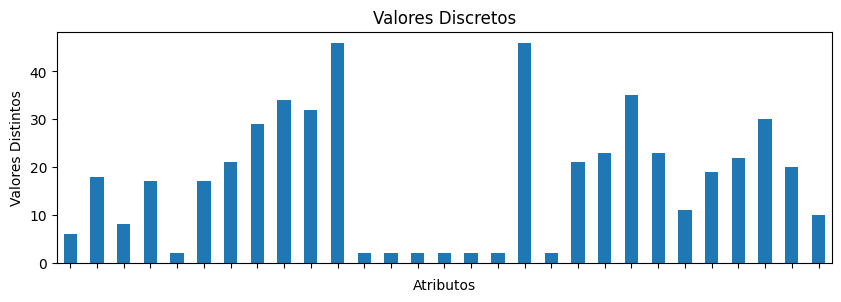

In [4]:
import matplotlib.pyplot as plt

int64_cols      = data.select_dtypes(include=['int64']).columns
unique_values   = data[int64_cols].nunique()

plt.figure(figsize=(10, 3))
ax = unique_values.plot(kind='bar')
plt.title('Valores Discretos')
plt.xlabel('Atributos')
plt.ylabel('Valores Distintos')
ax.set_xticklabels([])
plt.show()

### Algoritmo

El algoritmo a desarrollar es `ID3` como se presento en el teórico, con la incorporación de ciertos meta-parametros que buscan evitar el sobreajuste del modelo.

Para lograr este objetivo, se tuvo en consideración las siguientes subtareas:

1. Sobre las variables/estructuras necesarias para implementar `ID3` (Mitchell, 97, p86).
2. `ID3_utils.py`: Un modulo con estructuras/funciones auxiliares para la implementación de `ID3`.
3. `src.G02DecisionTrees.ID3Classifier`: Nuestro algoritmo inspirado en los clasificadores de `sklearn`..

#### Sobre las variables necesarias para implementar `ID3` (Mitchell, 97, p86).

Para implementar `ID3` necesitamos definir las siguientes variables:

Entradas:

- `Examples`: conjunto de ejemplos de entrenamiento (`train`).
- `Target_attribute`: atributo objetivo (`Target`).
- `Attributes`: conjunto de atributos (el resto de las columnas).

Estructura de Datos y Funciones Auxiliares:

- `node`: estructura de datos que representa un nodo del arbol.
- `max_gain_attr`: función que devuelve el atributo con mayor ganancia de información.
- `attributes_values`: diccionario que mapea atributos con todos sus valores posibles.


Para obtener `attributes_values` recorremos todos los atributos y obtenemos sus valores únicos. Hay que tener en cuenta que los atributos continuos fueron discretizados, por lo que sus valores son enteros que se encuentran en un rango acotado. (Preprocesamiento de atributos continuos).

El resto de las Estrucutras de Datos y Funciones Auxiliares se encuentran en el modulo `ID3_utils.py`.



In [5]:
import numpy as np

int64_cols      = data.select_dtypes(include=['int64']).columns
attrs_values    = {attr: sorted(data[attr].unique()) for attr in int64_cols}
float64_cols    = data.select_dtypes(include=['float64']).columns

attrs_values.update({col: list(range(5)) for col in float64_cols})

print(f'attrs: {len(attrs_values.keys())}, Algunos valores de atributos discretos: \n')
for k in list(attrs_values.keys())[:5]: print(f"{k}: {attrs_values[k]}")

attrs: 36, Algunos valores de atributos discretos: 

Marital status: [1, 2, 3, 4, 5, 6]
Application mode: [1, 2, 5, 7, 10, 15, 16, 17, 18, 26, 27, 39, 42, 43, 44, 51, 53, 57]
Application order: [0, 1, 2, 3, 4, 5, 6, 9]
Course: [33, 171, 8014, 9003, 9070, 9085, 9119, 9130, 9147, 9238, 9254, 9500, 9556, 9670, 9773, 9853, 9991]
Daytime/evening attendance	: [0, 1]


#### `ID3_utils.py`: Un módulo con estructuras/funciones auxiliares para la implementacion de `ID3`.

Este módulo de Python está diseñado para implementar árboles de decisión utilizando el algoritmo ID3. A continuación se describen los componentes principales:

- `ID3Node`: Esta es una clase que representa un nodo en el árbol de decisión. Cada nodo tiene una etiqueta (`label`) que indica el atributo que se está evaluando en ese nodo, y una ganancia de información (`info_gain`) que indica cuánta incertidumbre se reduce al dividir el conjunto de datos según ese atributo.
- `node`: Esta es una función auxiliar que facilita la creación de nuevos nodos. Acepta una etiqueta y una ganancia de información como argumentos y devuelve una instancia de `ID3Node`.
- `entropy`: Esta función calcula la entropía de un conjunto de datos dado un atributo objetivo (`attr_tget`). La entropía es una medida de la incertidumbre o el desorden en los datos.
- `max_gain_attr`: Esta función determina qué atributo tiene la máxima ganancia de información cuando se utiliza para evaluar el mejor nodo candidato.
- `evaluate`: Esta función evalúa un conjunto de datos y busca en el árbol de decisión para determinar la clase de cada ejemplo. Devuelve una lista de predicciones.

In [6]:
from src.ID3_utils import max_gain_attr, node

attr, gain  = max_gain_attr(train, 'Target', attrs_values)
id3_node    = node(attr, info_gain= gain)

id3_node.children[attrs_values[attr][0]] = node('Nationality', 0.02)

print(f"node: {id3_node.label, id3_node.info_gain, id3_node.children}")

node: ('Curricular units 2nd sem (approved)', 0.3231103604249548, {0: <src.ID3_utils.ID3Node object at 0x7f78542e3d30>})


#### `src.G02DecisionTrees.ID3Classifier`: Nuestro clase-clasificadora inspirada en `sklearn`.

Nuestro algoritmo esta encapsulado en una clase clasificadora que está diseñada/inspirada en base a los clasificadores de `scikit-learn`.
La principal motivacion para hacerlo de esta forma es el objetivo de comparar los resultados de nuestro algoritmo con los de `scikit-learn DecisionTreeClassifier, RandomForestClassifer`.

Entonces, consideramos acertado modelar esta clase como si se tratara de una clase más de `scikit-learn.`

**Clase ID3Classifier**: Define el clasificador ID3.

- `__init__`: Inicializa el clasificador con los meta-parametros. 
  - `min_samples_split` y `min_split_gain`: requeridas por la letra del obligatorio, limitan el crecimiento del arbol. 
  - `attr_values`, `attrs` necesarias para implementar `ID3` (Mitchell, 97, p86).

`ID3Classifier` implemeneta funciones típicas de `scikit-learn`:

- El método `fit` toma un DataFrame `X`, una serie `y` como entrada y construye un árbol de decisión con `_id3`.
- El método `predict` utiliza el árbol para hacer predicciones en un nuevo conjunto de datos.
- El método `score` evalúa la precisión del modelo utilizando `scikit-learn.accuracy_score`.
    
**`__id3`** implementa el algoritmo recursivamente para construir el árbol de decisión.

```python
## Mitchell, p. 68
def __id3(self, exs, attr_tget, attrs):
    same_value_attr_tget = exs[attr_tget].nunique() == 1
    attrs_empty = len(attrs) == 0
    
    if same_value_attr_tget or attrs_empty: return utils.node(exs[attr_tget].mode()[0])

    _attrs_values = { k: self.attrs_values[k] for k in attrs }
    best_attr, gain = utils.max_gain_attr(exs, attr_tget, _attrs_values)
    
    if gain <= self.min_split_gain: return utils.node(exs[attr_tget].mode()[0])
    
    node = utils.node(best_attr, gain)
    best_attr_values = self.attrs_values[best_attr]
    
    for attr_val in best_attr_values:
        exs_i = exs[exs[best_attr] == attr_val]

        if exs_i.shape[0] <= self.min_samples_split: 
          node.children[attr_val] = utils.node(exs[attr_tget].mode()[0])
        else:
          attrs_i = [attr for attr in attrs if attr != best_attr]
          node.children[attr_val] = self.__id3(exs_i, attr_tget, attrs_i)
    
    return node
```

***Nota***: 

Vamos a modificar la columna `Target`  de `train` para forzar la creacion de un ***`dummy classifier`***. En particular uno que siempre prediga `1` (inscripto o graduado). Obtendriamos un arbol de decision con un solo nodo hoja valor 1, como esta clase esta desbalanceada favorablemente, tendremos un accuracy alto.

In [7]:
from src.G02_decision_trees import ID3Classifier

train_X, train_y = train.drop(columns=['Target']), train['Target']
devel_X, devel_y = devel.drop(columns=['Target']), devel['Target']

G02_dumb_clf = ID3Classifier(attrs_values= attrs_values)
G02_dumb_clf.fit(train_X, train_y.apply(lambda x: 1))

print(f'{G02_dumb_clf.tree} [\
 label: {G02_dumb_clf.tree.label},\
 info_gain: {G02_dumb_clf.tree.info_gain},\
 children: {G02_dumb_clf.tree.children} ]'
)

G02_dumb_clf.score(devel_X, devel_y)

<src.ID3_utils.ID3Node object at 0x7f77adc3aaa0> [ label: 1, info_gain: 1.0, children: {} ]


0.6790960451977401

### Evaluación

Como se nos ha comentado en el teorico, la evaluación de un modelo es una tarea compleja que requiere de un análisis profundo de los resultados obtenidos.
En particular, la seleccion de metricas acorde al problema a resolver es una tarea que requiere de un conocimiento profundo del dominio.

Sabemos que el dataset que estamos analizando tiene un desbalance en el atributo objetivo `Target`, por lo que la métrica de `accuracy` no es la más adecuada para evaluar el modelo. Por ejemplo un modelo que siempre prediga un resultado con el valor de una clase favorable, tendra un accuracy elevado (`G02_dumb_clf`) 

Vamos a utilizar la metrica [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) para evaluar el modelo, es adecuada para problemas con clases desbalanceadas.

Como ya comentamos anteriormente, nuestro equipo convenientemente separó los datos en tres conjuntos:

- `train`: para entrenar el modelo.
- `devel`: para ajustar los hiperparametros y evaluaciones intermedias.
- `test`: para evaluar el modelo final.

Se utilizo una proporcion 60/20/20 para los conjuntos `train`, `devel` y `test` respectivamente. Estos conjuntos ademas se encuentran mezclados de forma aleatoria y estraficados, de forma tal que la proporcion de clases sea la misma en los tres conjuntos.

***Nota***:

Impremiremos esta proporcion para dejar constancia. De la documentacion de `sklearn.model_selection.train_test_split` se desprende que la estratificacion es un comportamiento predeterminado.

In [8]:
train_target_proportion = train_y.value_counts(normalize=True)
devel_target_proportion = devel_y.value_counts(normalize=True)

print(f'Train: {train_target_proportion}\n')
print(f'Devel: {devel_target_proportion}')

Train: Target
1    0.680482
0    0.319518
Name: proportion, dtype: float64

Devel: Target
1    0.679096
0    0.320904
Name: proportion, dtype: float64


## Experimentación

En este apartado vamos a realizar una serie de experimentos.

- Busqueda con Grid Search para encontrar los mejores hiperparametros de nuestro modelo.
- Definicion de nuestro modelo final.
- Exploracion de los modelos de `scikit-learn DecisionTreeClassifier, RandomForestClassifer`.
- Comparativa final de los modelos.

### Grid Search para encontrar los mejores hiperparametros de nuestro modelo.

Para encontrar la mejor combinacion de meta-parametros para nuestro clasificador vamos a utilizar Grid Search. 

Primero vamos a definir un espacion de busqueda tomando ciertas precauciones. La idea de los meta-parametros es evitar el sobreajuste del modelo, sin estos elementos, un arbol de decision puede crecer hasta tener un nodo por cada ejemplo de entrenamiento. 

Por ende, un arbol con muchos nodos es un arbol que esta sobreajustado. De forma analoga, tampoco queremos un arbol que solo tenga un nodo, como el `G02_dumb_clf` que siempre predice `1`.

Sabemos que:

- `min_samples_split` &rarr; cantidad mínima de ejemplos para generar un nuevo nodo.
- `min_split_gain` &rarr; ganancia mínima requerida para partir por un atributo.

No satisfacer estas condiciones fuerza la creacion de un nodo hoja con el valor mas comun del atributo objetivo `Target`.

Definimos el espacio de busqueda de la siguiente forma:

- `min_samples_split` &rarr; (0, 885)
- `min_split_gain` &rarr; (0.0, 0.325):

En cada iteracion de `ID3` el conjunto de entrenamiento se reduce en factor de cuantos ejemplos habia para el valor del atributo pivotal. Por ejemplo, si el atributo pivotal es `Nationality` y el valor es `Uruguay`, entonces el conjunto de entrenamiento se reduce a los ejemplos que tienen `Nationality == Uruguay`. 

En resumen, el conjunto de ejemplos se reduce en factor del valor del atributo pivotal. `devel` tiene 885 ejemplos, es decir un 20% de los ejemplos de `train`. Nuestro metodo de grid search va a iterar entre el 0% y el 20% de la cantidad total de ejemplos de `train`.

El limite superior surge de la ganancia maxima de un atributo en todo `train`. El limite inferior es 0.0 porque es el valor predeterminado.

In [9]:
from src.ID3_utils import max_gain_attr
from src.G02_decision_trees import ID3Classifier
from sklearn.metrics import f1_score
import os, numpy as np, pandas as pd

GRID_SAMPLES = 10

attr, gain = max_gain_attr(train, 'Target', attrs_values)
train_X, train_y = train.drop(columns=['Target']), train['Target']
devel_X, devel_y = devel.drop(columns=['Target']), devel['Target']

meta_params_grid = {
    'min_samples_split': np.linspace(devel.shape[0], 2, GRID_SAMPLES).astype(int),
    'min_split_gain': np.linspace(gain, 0.0, GRID_SAMPLES)
}

def grid_search_to_csv():
    results = pd.DataFrame(columns=['f1_score', 'min_samples_split', 'min_split_gain'])

    for mss_i in meta_params_grid['min_samples_split']:
        for msg_j in meta_params_grid['min_split_gain']:
            clf = ID3Classifier(attrs_values=attrs_values, min_samples_split= mss_i, min_split_gain= msg_j)
            clf.fit(train_X, train_y)
            results.loc[len(results)] = [f1_score(devel_y, clf.predict(devel_X)), mss_i, msg_j]

    results.to_csv('assets/grid_search.csv', index=False)

if not os.path.exists('assets/grid_search.csv'): grid_search_to_csv()

### Definicion de nuestro modelo final.

Despues de evaluar 100 modelos con grid search, construimos un `CSV` con los resultados obtenidos.

- `grid_search.csv`: Resultados de la busqueda con grid search.

Vamos a utilizar `pandas` para obtener el promedio de los meta-parametros que obtuvieron el mejor `f1_score`.

Obteniendo asi los meta-parametros para nuestro modelo final:

In [10]:
import pandas as pd
from src.G02_decision_trees import ID3Classifier

grid_search = pd.read_csv('assets/grid_search.csv')

max_f1_score = grid_search['f1_score'].max()
best_params = grid_search[grid_search['f1_score'] == max_f1_score].iloc[0]

max_min_samples_split = best_params['min_samples_split'].mean().astype(int)
max_min_split_gain = best_params['min_split_gain'].mean()

G02_best_clf = ID3Classifier(attrs_values=attrs_values, min_samples_split=max_min_samples_split,
                             min_split_gain=max_min_split_gain)

G02_best_clf.fit(train_X, train_y)

print(f'f1_score(devel): {f1_score(devel_y, G02_best_clf.predict(devel_X))}')

f1_score(devel): 0.8809338521400778


### Construccion de los clasificadores `scikit-learn DecisionTreeClassifier, RandomForestClassifer`.

Vamos a indagar en los siguientes clasificadores `scikit-learn DecisionTreeClassifier, RandomForestClassifer`. Sobre todo manipular sus metaprametros para que, en la medida de lo posible, nuestro mejor clasificador compita con ellos en igualdad de condiciones.

Por igualdad de condiciones nos referimos a las siguientes consideraciones:

- **Metaparametros**: Utilizar los mismos metaparametros que nuestro mejor clasificador. De no encontrar/detectar un metaparametro equivalente, utilizar el valor por defecto.
- **Entreanamiento**: Utilizar el mismo conjunto de entrenamiento que nuestro mejor clasificador.
- **Evaluacion**: Utilizar la misma metrica de evaluacion que nuestro mejor clasificador.

Tomamos estas consideraciones porque asumimos que los clasificadores de `scikit-learn` son robustos y estan optimizados para obtener los mejores resultados posibles.

#### `scikit-learn DecisionTreeClassifier`

Identificamos los siguientes metaparametros:

- `criterion`: La funcion para medir la calidad de una particion. Utilizamos `entropy` porque es la misma que utiliza nuestro clasificador.
- `min_samples_split`: Su definicion es la misma que la de nuestro clasificador. Utilizamos el valor de nuestro mejor clasificador que casualmente es el valor por defecto.

No existe un metaparametro equivalente a `min_split_gain`.

#### `scikit-learn RandomForestClassifer`

De forma similar al clasificador anterior, identificamos los siguientes metaparametros:

- `criterion`: analogo al clasificador anterior, utilizamos `entropy`.
- `min_samples_split`: analogo al clasificador anterior, utilizamos el valor por defecto.

No existe un metaparametro equivalente a `min_split_gain`.

En resumen, los clasificadores que consideramos mas cercanos a nuestro mejor clasificador son:

- `DecisionTreeClassifier` con `criterion='entropy'` y `min_samples_split=2`.
- `RandomForestClassifer` con `criterion='entropy'` y `min_samples_split=2`.

***Nota***:

Hay un parametro llamado `min_impurity_decrease` que es similar a `min_split_gain`, es una formula que aplica tecnicas de look-ahead para determinar si un nodo debe ser dividido. Dado que nuestro clasificador es puramente greedy, no tiene sentido utilizarlo.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

train_X, train_y = train.drop(columns=['Target']), train['Target']
devel_X, devel_y = devel.drop(columns=['Target']) , devel['Target']

fair_dt_clf = DecisionTreeClassifier(criterion= 'entropy')
fair_dt_clf.fit(train_X, train_y)

fair_rf_clf = RandomForestClassifier(criterion= 'entropy')
fair_rf_clf.fit(train_X, train_y)

print(f'DecisionTreeClassifier f1_score(devel): {f1_score(devel_y, fair_dt_clf.predict(devel_X))}')
print(f'RandomForestClassifier f1_score(devel): {f1_score(devel_y, fair_rf_clf.predict(devel_X))}')

DecisionTreeClassifier f1_score(devel): 0.848585690515807
RandomForestClassifier f1_score(devel): 0.9092356687898089


### Comparativa final de los modelos.

En este apartado vamos a comparar el desempeño de los modelos que hemos construido. Recordemos brevemente cuales son:

- `G02_dumb_clf`: Un clasificador que siempre predice `1` (inscripto o graduado).
- `G02_best_clf`: Nuestro mejor clasificador con los meta-parametros que obtuvieron el mejor `f1_score`.
- `fair_dt_clf`: `DecisionTreeClassifier` con `criterion='entropy'`.
- `fair_rf_clf`: `RandomForestClassifer` con `criterion='entropy'`.

In [14]:
test_X, test_y = test.drop(columns=['Target']), test['Target']

fair_dt_pred = fair_dt_clf.predict(test_X)
fair_rf_pred = fair_rf_clf.predict(test_X)
G02_best_pred = G02_best_clf.predict(test_X)
G02_dumb_pred = G02_dumb_clf.predict(test_X)

print(f'DecisionTreeClassifier  f1_score(test): {f1_score(test_y, fair_dt_pred)}')
print(f'RandomForestClassifier  f1_score(test): {f1_score(test_y, fair_rf_pred)}')
print(f'Best ID3Classifier      f1_score(test): {f1_score(test_y, G02_best_pred)}')
print(f'Dumb ID3Classifier      f1_score(test): {f1_score(test_y, G02_dumb_pred)}')

DecisionTreeClassifier  f1_score(test): 0.8479729729729729
RandomForestClassifier  f1_score(test): 0.900726392251816
Best ID3Classifier      f1_score(test): 0.8871473354231976
Dumb ID3Classifier      f1_score(test): 0.8048615800135044


## Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?

#### Comparación de salidas

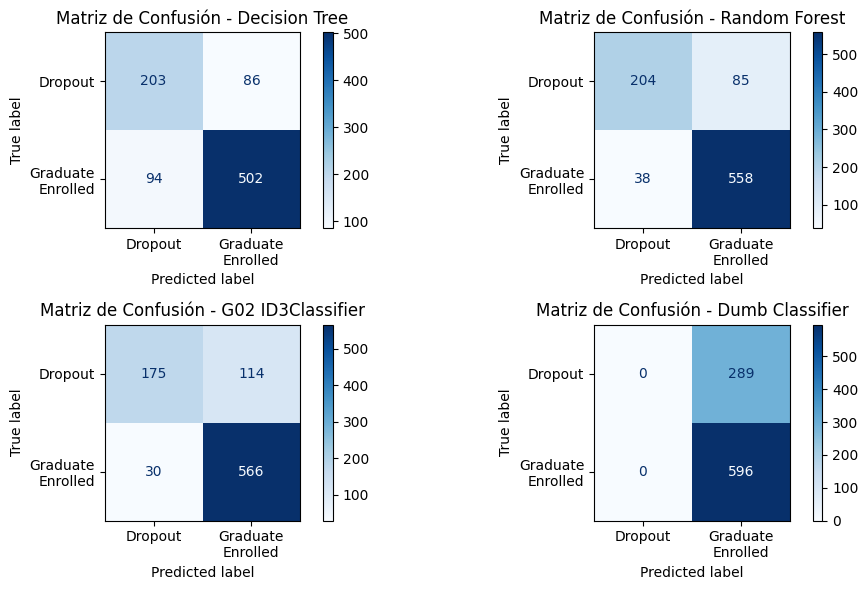

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matrices de confusión
cm_decision_tree = confusion_matrix(test_y, fair_dt_pred)
cm_random_forest = confusion_matrix(test_y, fair_rf_pred)
cm_G02_best_clf = confusion_matrix(test_y, G02_best_pred)
cm_G02_dumb_clf = confusion_matrix(test_y, G02_dumb_pred)

# 0 = Dropout, 1 = Graduate or Enrolled
labels = ['Dropout', 'Graduate\nEnrolled']

## Crear objetos ConfusionMatrixDisplay
cmd_decision_tree = ConfusionMatrixDisplay(confusion_matrix=cm_decision_tree, display_labels=labels)
cmd_random_forest = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest, display_labels=labels)
cmd_G02_best_clf = ConfusionMatrixDisplay(confusion_matrix=cm_G02_best_clf, display_labels=labels)
cmd_G02_dumb_clf = ConfusionMatrixDisplay(confusion_matrix=cm_G02_dumb_clf, display_labels=labels)

# Mostrar las matrices de confusión
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

cmd_decision_tree.plot(cmap=plt.cm.Blues, ax=axes[0][0])
axes[0][0].set_title("Matriz de Confusión - Decision Tree")

cmd_random_forest.plot(cmap=plt.cm.Blues, ax=axes[0][1])
axes[0][1].set_title("Matriz de Confusión - Random Forest")

cmd_G02_best_clf.plot(cmap=plt.cm.Blues, ax=axes[1][0])
axes[1][0].set_title("Matriz de Confusión - G02 ID3Classifier")

cmd_G02_dumb_clf.plot(cmap=plt.cm.Blues, ax=axes[1][1])
axes[1][1].set_title("Matriz de Confusión - Dumb Classifier")

plt.tight_layout()
plt.show()